# Accessing and using OBIS species distribution models

Predictions and the raw (quality-controlled) data, as well as additional files (e.g. model metrics) are available through both the mapping platform and AWS S3.

To explore the files available, go to https://obis-maps.s3.amazonaws.com/index.html

## Folder structure

Outputs stored in this bucket always follow the same standard structure. File names will always contain at least two components:

`taxonid=[AphiaID]`: identify the taxon
`model=[Model run acronym]`: identify the modelling exercise

Additional information also follow a similar syntax (inspired on the hive format) and is identified by "[the parameter]=[the value]". For example, a prediction file for a species will look like this:

`taxonid=135185_model=mpaeu_method=maxent_scen=ssp126_dec100_cog.tif`

`method` is the algorithm used for the model and `scen` the scenario and period of the prediction. In this case `_cog` simply indicates that the output is COG optimized.

A species folder have the following structure:

```
├── figures                    : Plots for quick exploration of results
├── metrics                    : All metrics and additional information (e.g. CV metrics, response curves, etc.)
├── models                     : RDS files containing the fitted models, ready for predicting in new data
├── predictions                : The TIF files with predictions
│
├── ..._what=fitocc.parquet    : Occurrence points used to fit the model
└── ..._what=log.json          : The log file containing all model fit details
```

Here we will focus on the **predictions** folder, but you can learn more about the whole structure in the [OBIS SDM documentation](https://iobis.github.io/mpaeu_docs/datause.html).

## Loading a prediction

Let's explore one prediction for the species *Sebastes norvegicus* ([AphiaID 126426](https://obis.org/taxon/151324)).

The easiest way to work with raster (GeoTIFF) files on R is using the `terra` package (alternatively, you can work with package `stars`).

To open a single prediction for the current period, you can use the following code:

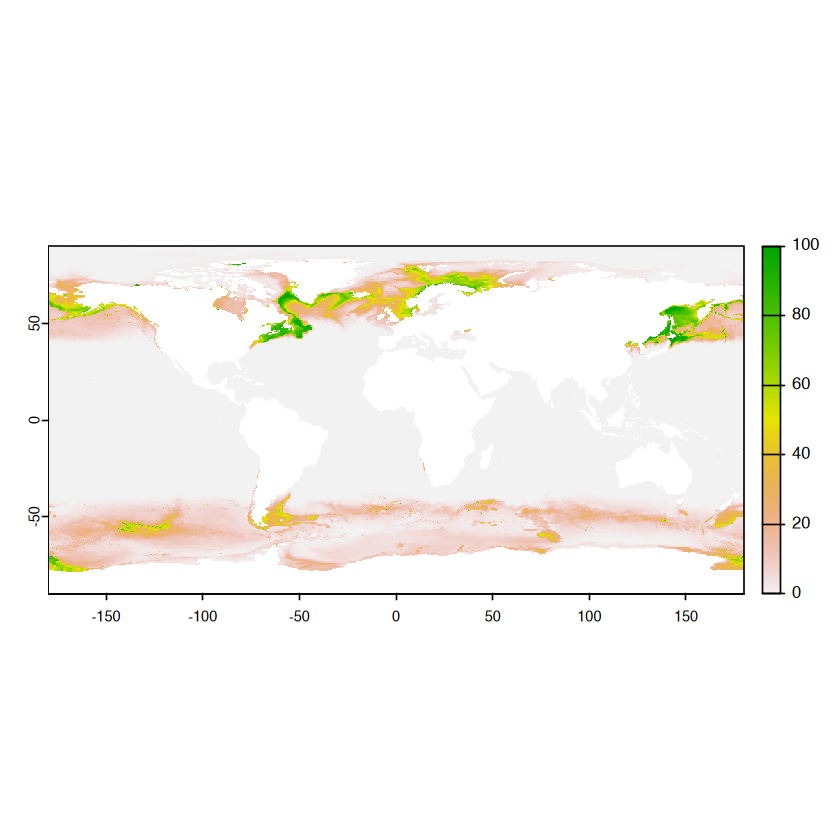

In [ ]:
suppressPackageStartupMessages(library(terra))
suppressPackageStartupMessages(library(glue))

aws_path <- "https://obis-maps.s3.amazonaws.com/results/species"
species <- 151324
model <- "mpaeu" # acronym identifying model realization
algo <- "maxent" # SDM method

current <- glue(
    "taxonid={species}/model={model}/predictions/taxonid={species}_model={model}_method={algo}_scen=current_cog.tif"
)
current <- rast(file.path(aws_path, current))

plot(current)

All predictions folders always include a mask file. Let’s also open this file. The maskfile is a multiband raster, with each band being a different mask. We plot here the "fit_region" mask. We also load the occurrence records used to fit the model and overlay it to the mask.

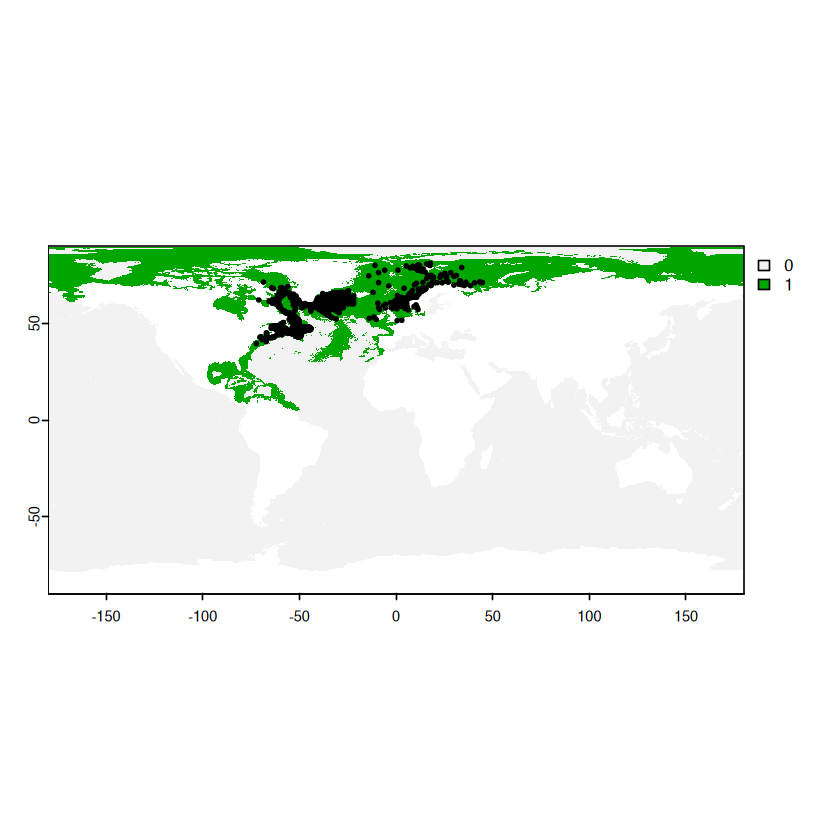

In [2]:
mask_file <- glue(
    "taxonid={species}/model={model}/predictions/taxonid={species}_model={model}_mask_cog.tif"
)
mask_file <- rast(file.path(aws_path, mask_file))
plot(mask_file$fit_region)

pts <- glue(
    "taxonid={species}/model={model}/taxonid={species}_model={model}_what=fitocc.parquet"
)
pts <- arrow::read_parquet(file.path(aws_path, pts))
points(pts, pch = 20, cex = .5)

Predictions show the relative suitability of a place, in terms of its environmental conditions. However, predictions are made to the whole globe, including areas which may not be reachable by the species. Thus, it is always advisable to mask the predictions by one of the masks provided (or you can create one based on your knowledge/data). In this case, we will use the mask which was just shown.

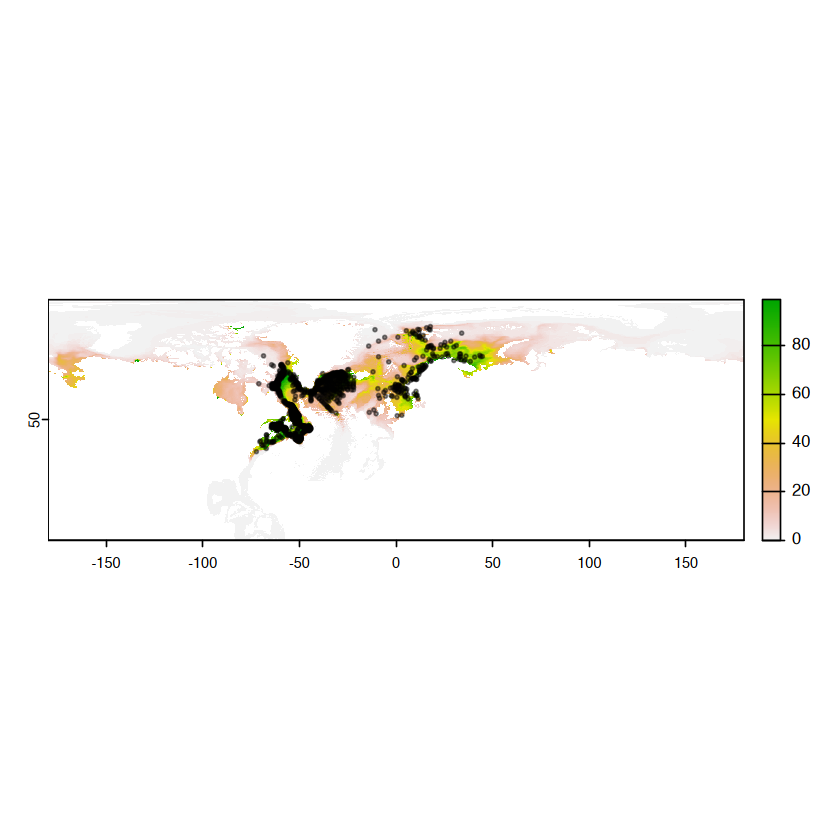

In [3]:
# Masks are saved with 0/1. So we need to define 0 as our NA value
NAflag(mask_file) <- 0

current_masked <- mask(current, mask_file$fit_region)

plot(current_masked, ylim = c(10, 90)) # Limit for better visualization
points(pts, pch = 20, cex = .5, col = "#00000075")


Now that we masked the prediction, we may want to limit it to only areas that are more likely to have the species according to a certain threshold. Here we will apply the P10 threshold (i.e. the 10th percentile of suitability values at occurrence locations) to remove areas of low suitability.

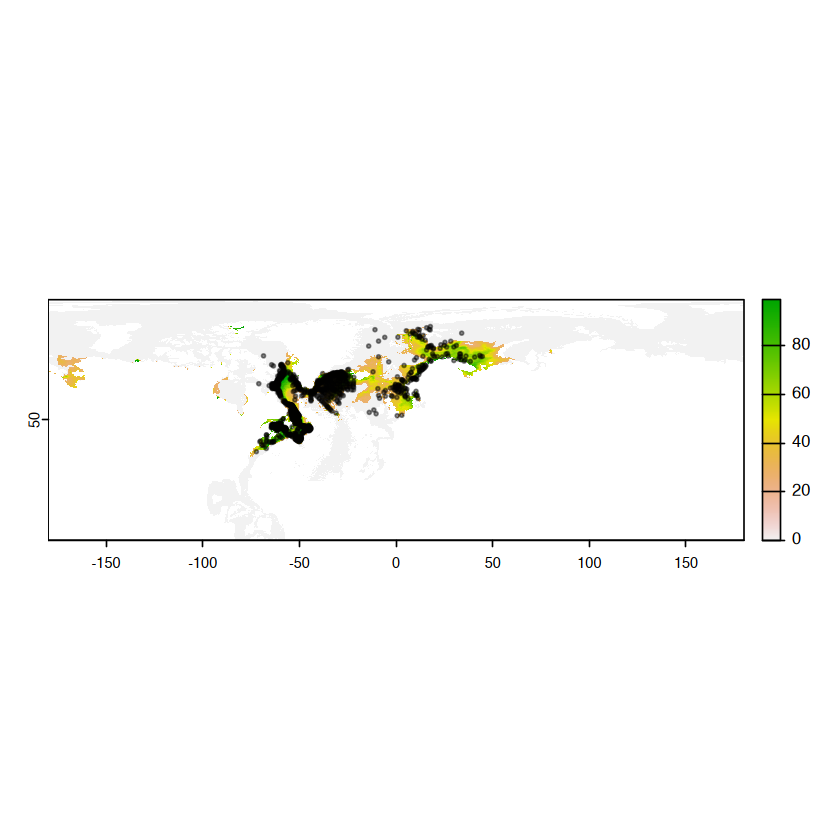

In [4]:
thresholds <- glue(
    "taxonid={species}/model={model}/metrics/taxonid={species}_model={model}_what=thresholds.parquet"
)
thresholds <- arrow::read_parquet(file.path(aws_path, thresholds))

th <- thresholds$p10[thresholds$model == algo]

current_thresholded <- classify(
    current_masked,
    matrix(c(-Inf, (th * 100), 0), nrow = 1)
)

plot(current_thresholded, ylim = c(10, 90)) # Limit for better visualization
points(pts, pch = 20, cex = .5, col = "#00000075")

You can explore more in depth how to work with the SDMs, and specially understand the limitations of the models, in the [OBIS SDM documentation](https://iobis.github.io/mpaeu_docs/).